# Molecular Dynamics
## Initializing a system to a specific density using HOOMD 3

HOOMD 3 is still in beta. This tutorial requires compiling hoomd from [source](https://github.com/glotzerlab/hoomd-blue) on the branch `/feature/new-object-API`. More instructions can be found in [the hoomd docs](https://hoomd-blue.readthedocs.io/en/feature-new-object-api/installation.html).

mbuild was installed from [PR 698](https://github.com/mosdef-hub/mbuild/pull/698). 

and the environment was created using:
```
conda create -n cmelab-hoomd3 -c conda-forge -c mosdef -c omnia 'python=3.7' pip matplotlib numpy scipy packmol 'nglview>=2.7' oset parmed mdtraj foyer openbabel py3Dmol 'nodejs>=10' jupyterlab unyt
```

<a id="toc"></a>
## Table of Contents
- [initialize a system](#init)

In [1]:
import foyer
import hoomd
import matplotlib.pyplot as plt
import mbuild as mb
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
import numpy as np
import parmed as pmd

<a id="init"></a>
## Starting Structure


[back to top](#toc)

In [2]:
propane = mb.load("CCC", smiles=True)

propane.visualize().show()

/Users/jenny/miniconda3/envs/cmelab-hoomd3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jenny/miniconda3/envs/cmelab-hoomd3/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
/Users/jenny/Projects/mbuild/mbuild/compound.py:2749: UserWarning: No unitcell detected for pybel.Molecule CCC	

  warn("No unitcell detected for pybel.Molecule {}".format(pybel_mol))


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In the above visualization, carbon atoms are colored grey and hydrogens are white. 

Let's say we want a system of liquid propane at a density of 0.6 g/mL.
mBuild and foyer use these [units](http://docs.openmm.org/7.2.0/userguide/theory.html#units) (nm, amu)

1 amu = 1.66054e-24 g

1 mL = 1 cm$^{3}$ = 1e21 nm$^{3}$

For simplicity, let's say that each propane molecule is 44 amu (3 carbons @12 amu + and 8 hydrogens @1 amu)

If our box volume is 5x5x5 nm (125 nm$^{3}$), then how many propane molecules do we need to fill it at this density?

In [24]:
box = mb.Box([5,5,5])
system_box = mb.packing.fill_box(propane, 1027, box=box)
system_box.visualize().show()

/Users/jenny/miniconda3/envs/cmelab-hoomd3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<a id="ff"></a>
## Apply forcefield


_Side note: The `foyer.Forcefield.apply` function currently generates a [parmed structure](https://parmed.github.io/ParmEd/html/structure.html), which does not have the same convenient system-building operations as mbuild. This is why we can't fill the box with our typed molecule. The typed molecule was shown above simply to demonstrate which atoms are assigned the different types. With the new [GMSO](https://gmso.mosdef.org/en/latest/) back-end, this workflow may change._

[back to top](#toc)

In [25]:
oplsaa = foyer.forcefields.load_OPLSAA()
box_struc = oplsaa.apply(system_box, assert_dihedral_params=False)

/Users/jenny/miniconda3/envs/cmelab-hoomd3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jenny/miniconda3/envs/cmelab-hoomd3/lib/python3.7/site-packages/foyer/forcefield.py:449: UserWarning: No force field version number found in force field XML file.
  'No force field version number found in force field XML file.'
/Users/jenny/miniconda3/envs/cmelab-hoomd3/lib/python3.7/site-packages/foyer/forcefield.py:461: UserWarning: No force field name found in force field XML file.
  'No force field name found in force field XML file.'
/Users/jenny/miniconda3/envs/cmelab-hoomd3/lib/python3.7/site-packages/foyer/validator.py:132: ValidationWarning: You have empty smart definition(s)
  warn("You hav

<a id="run"></a>
## Run simulation

Now that we have our simulation volume, we can set up our MD simulation to run in [HOOMD](https://hoomd-blue.readthedocs.io/en/stable/) using mbuild's `create_hoomd_simulation` funciton. This will read in the atom positions, bonding information, and forcefield parameters that we have already set. Additionally we need to tell HOOMD about the temperature ([kT, really the thermal energy](https://hoomd-blue.readthedocs.io/en/stable/units.html)), the thermostat coupling (tau), the cutoff where the particles no longer "feel" each other (r_cut), and the time step (dt). Everything else set in the cell below is telling HOOMD how often/when to write out data. The [gsd](https://gsd.readthedocs.io/en/stable/) files will contain the simulation snapshots and the log file will record quantities as the simulation progresses. 

_(the cell below takes about 10 mins to run on 1.6GHz dual-core Intel Core i5)_

[back to top](#toc)

In [29]:
snapshot, forcefield, nlist, values = create_hoomd_simulation(
    box_struc, r_cut=1.2, auto_scale=True
)

/Users/jenny/miniconda3/envs/cmelab-hoomd3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing LJ and QQ
Processing 1-4 interactions, adjusting neighborlist exclusions
Processing harmonic bonds
Processing harmonic angles
Processing RB torsions
HOOMD SimulationContext updated from ParmEd Structure


In [41]:
forcefield

/Users/jenny/miniconda3/envs/cmelab-hoomd3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
langevin = hoomd.md.methods.Langevin(
    filter=hoomd.filter.All(), kT=1.0, seed=1
)

integrator = hoomd.md.Integrator(
    dt=0.0001, methods=[langevin], forces=forcefield
)

gsd = hoomd.dump.GSD(
    filename='traj.gsd', 
    trigger=hoomd.trigger.Periodic(int(1e5)),
    overwrite=True
)

/Users/jenny/miniconda3/envs/cmelab-hoomd3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RuntimeError: Object cannot be added to two lists.

In [32]:
hoomd.trigger.Periodic

/Users/jenny/miniconda3/envs/cmelab-hoomd3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Box',
 'Operations',
 'Simulation',
 'Snapshot',
 'State',
 'WalltimeLimitReached',
 '__builtins__',
 '__cached__',
 '__compile_flags__',
 '__compiler_version__',
 '__cuda_version__',
 '__doc__',
 '__file__',
 '__git_refspec__',
 '__git_sha1__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_bib',
 '_default_excepthook',
 '_hoomd',
 '_hoomd_sys_excepthook',
 'analyze',
 'array',
 'benchmark',
 'box',
 'cite',
 'comm',
 'compute',
 'ctypes',
 'custom',
 'data',
 'dem',
 'device',
 'dump',
 'filter',
 'flags',
 'hpmc',
 'init',
 'integrate',
 'lattice',
 'logging',
 'md',
 'meta',
 'operation',
 'operations',
 'option',
 'os',
 'output',
 'parameterdicts',
 'simulation',
 'smart_default',
 'snapshot',
 'state',
 'syncedlist',
 'sys',
 'trigger',
 'tune',
 'typeconverter',
 'typeparam',
 'update',
 'util',
 'variant']

<a id="analysis"></a>
## Analysis
Now that we have a finished simulation, we can run some analysis.

[back to top](#toc)

<a id='vis'></a>
### Visualise Simulation
First let's see what's actually going on in our simulation. This can be done in [VMD](https://www.ks.uiuc.edu/Research/vmd/) or we can use the `display_movie` and `snap_render` functions which are wrappers for [fresnel](https://fresnel.readthedocs.io/en/stable/), an open-source ray-tracer.

In [7]:
gsdfile = "opv_trajectory.gsd"
gaff_colors_cpk = {
    'cc_r5': 'grey',
    'ss'   : 'yellow',
    'h4'   : 'white',
    'ha'   : 'white',
    'c3'   : 'grey',
    'hc'   : 'white',
}

display_movie(
    snap_render, gsdfile, color=gaff_colors_cpk, gif="images/opv_trajectory.gif", height=35
)

This simulation is just designed to be a quick introduction, but we can see that this trajectory probably wasn't run long enough for the polymers to equilibrate.

![](images/opv_trajectory.gif)

<a id='plot'></a>
### Plotting simulation quantities

Another way to determine if your simulation is equilibrated is to plot the quantities from the logfile. In the above example we logged timestep (logged by default), time, temperature, and potential_energy.

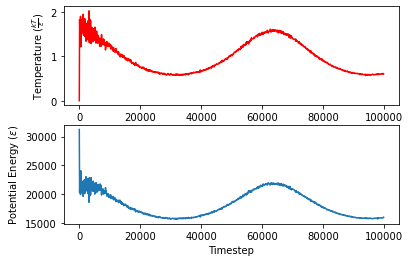

In [8]:
log_data = np.loadtxt("opv_out.log", skiprows=1)
timestep = log_data[:,0]
temp = log_data[:,2]
potential = log_data[:,3]

fig, (ax1,ax2) = plt.subplots(2)
ax1.plot(timestep,temp, 'r-')
ax1.set_xlabel("Timestep")
ax1.set_ylabel(r"Temperature ($\frac{kT}{\epsilon}$)")

ax2.plot(timestep,potential)
ax2.set_xlabel("Timestep")
ax2.set_ylabel(r"Potential Energy ($\epsilon$)");

From the above plot we can see the potential energy and temperature appear to be oscillating, which suggests the system is not equillibrated and there are likely problems with the thermostat coupling (tau). To learn how to fix this issue, check out the temperature-thermostat notebook in this repo.

<a id='rdf'></a>
### Radial Distribution Function (RDF)

<img src="http://www.physics.emory.edu/faculty/weeks/idl/pics/gr1.gif" width="200" height="200" /> <img src="http://www.physics.emory.edu/faculty/weeks/idl/pics/gr2c.gif" width="250" height="250" />

Image credit [Emory University Physics](http://www.physics.emory.edu/faculty/weeks/idl/gofr.html)

The radial distribution function calculates the distribution of nearest neighbors for each particle. It can be used to determine the phase (solid, liquid, gas) of a system or degree of crystalinity. The above image shows the RDF for the black particle in the center.

The `gsd_rdf` function is a wrapper for [freud](https://freud.readthedocs.io/en/stable/)'s rdf class. Below we are calculating the RDF between the thiophene sulfurs. 

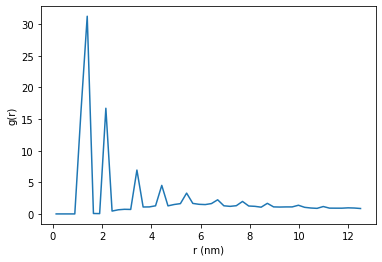

In [10]:
rdf = gsd_rdf("opv_trajectory.gsd", "ss", "ss", start=-10)
plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.show()

Because this trajectory is not equilibrated, this RDF is most likely showing the intrachain sulfur to sulfur distances which are controlled by the bonding forces as opposed to the more interesting interchain distances which could tell us more about $\pi-\pi$-stacking and the morphology in general. 

<img src="https://www.researchgate.net/profile/Francis_Spano/publication/263704875/figure/fig7/AS:325430251933714@1454600026675/4-4-p-stack-showing-the-intra-and-interchain-interactions-We-assume-a-square-lattice.png" width="250" height="250" />

Image from [Pochas, C.; Spano, F. **2014** *J. Chem. Phys.*](https://doi.org/10.1063/1.4882696)

For more on calculating RDFs and how to interpret them check out the radial-distribution-function notebook in this repo.